<a href="https://colab.research.google.com/github/avalonavelly/avalonavelly.github.com/blob/main/40%EA%B8%B0%20%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Collect the stock data

In [2]:
import pandas_datareader as pdr

df = pdr.get_data_tiingo('AAPL', api_key="3de1ada35851c6f24b413fbba03d523301d64bcc")
df
#굳이 csv로 바꾸는 이유는 Tiingo api는 하루에 50번만 부를 수 있음. 그런데 이렇게 csv로 바꾸면 무제한으로 부를 수 있기 때문.
df.to_csv('AAPL.csv')

In [3]:
import pandas as pd
df = pd.read_csv('AAPL.csv')
df
df.head()
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,AAPL,2021-05-07 00:00:00+00:00,130.21,131.2582,129.475,130.85,78973273,130.21,131.2582,129.475,130.85,78973273,0.22,1.0
1254,AAPL,2021-05-10 00:00:00+00:00,126.85,129.5400,126.810,129.41,88071229,126.85,129.5400,126.810,129.41,88071229,0.00,1.0
1255,AAPL,2021-05-11 00:00:00+00:00,125.91,126.2700,122.770,123.50,126142826,125.91,126.2700,122.770,123.50,126142826,0.00,1.0
1256,AAPL,2021-05-12 00:00:00+00:00,122.77,124.6400,122.250,123.40,112172282,122.77,124.6400,122.250,123.40,112172282,0.00,1.0
1257,AAPL,2021-05-13 00:00:00+00:00,124.97,126.1500,124.260,124.58,105861339,124.97,126.1500,124.260,124.58,105861339,0.00,1.0


In [4]:
#close칼럼을 고르자 
df1 = df.reset_index()['close']
df1
df1.shape

(1258,)

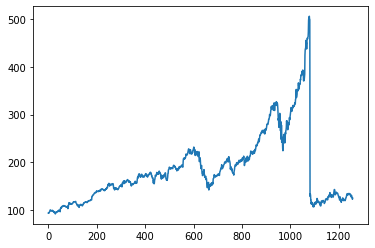

In [5]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
# LSDM are sensitive to the scale of the data. so we apply MinMax scaler
즉 close 데이터들 중에 가장 작은 값을 0으로, 가장 큰값을 1로 바꿔주는 작업해야하고, 그러기위해 numpy 필요

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))
df1

array([[0.00444391],
       [0.00350199],
       [0.00608622],
       ...,
       [0.08180171],
       [0.07421809],
       [0.07953146]])

# 2. Preprocess the Data
* timeseries data(sequence of data)는 70퍼는 Train데이터로, 나머지 30퍼는 테스트 데이터로
*  이제 데이터 preprocess하자.

In [7]:
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size

train_data = df1[0: training_size, :]
test_data = df1[training_size: len(df1), :1]

training_size, test_size
len(train_data)

817

In [8]:
import numpy as np
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i+time_step, 0])
  return np.array(dataX), np.array(dataY)



In [9]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print(X_train)
print(X_train.shape, y_train.shape)

[[0.00444391 0.00350199 0.00608622 ... 0.04946263 0.05062191 0.05074266]
 [0.00350199 0.00608622 0.00521676 ... 0.05062191 0.05074266 0.0527714 ]
 [0.00608622 0.00521676 0.00768023 ... 0.05074266 0.0527714  0.05318198]
 ...
 [0.23180775 0.22820915 0.23214588 ... 0.24465644 0.25349595 0.2584229 ]
 [0.22820915 0.23214588 0.24888299 ... 0.25349595 0.2584229  0.26902548]
 [0.23214588 0.24888299 0.23912571 ... 0.2584229  0.26902548 0.26313247]]
(716, 100) (716,)


In [11]:
#reshape input to be 3dimensional. [samples, time_steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, y_train.shape)

(716, 100, 1) (716,)


3. Create LSTM model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [13]:
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer='adam')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 8s 295ms/step - loss: 0.0161 - val_loss: 0.0450
Epoch 2/100
12/12 [==============================] - 2s 183ms/step - loss: 0.0027 - val_loss: 0.0246
Epoch 3/100
12/12 [==============================] - 2s 184ms/step - loss: 0.0013 - val_loss: 0.0255
Epoch 4/100
12/12 [==============================] - 2s 181ms/step - loss: 7.0043e-04 - val_loss: 0.0211
Epoch 5/100
12/12 [==============================] - 2s 184ms/step - loss: 4.8032e-04 - val_loss: 0.0186
Epoch 6/100
12/12 [==============================] - 2s 187ms/step - loss: 3.9458e-04 - val_loss: 0.0185
Epoch 7/100
12/12 [==============================] - 2s 188ms/step - loss: 4.0066e-04 - val_loss: 0.0181
Epoch 8/100
12/12 [==============================] - 2s 186ms/step - loss: 3.9492e-04 - val_loss: 0.0179
Epoch 9/100
12/12 [==============================] - 2s 191ms/step - loss: 3.7452e-04 - val_loss: 0.0176
Epoch 10/100
12/12 [==============================] - 2s 184ms/step

#. Predict the test data and plot the output

In [16]:
#Let's do the prediction check performance matrix
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [17]:
# Transform back to original form(3차원을 다시 2차원으로)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [18]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

170.3183604838142

In [19]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

238.6423533571391

# Plotting

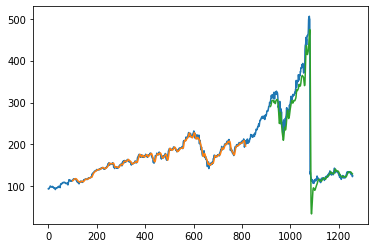

In [20]:
# shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# 5. Predict the future 30 days and plot the output

In [21]:
len(test_data)

441

In [22]:
x_input = test_data[340:].reshape(1, -1)
x_input.shape

(1, 101)

In [23]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.08854003139717423,
 0.08360101437024511,
 0.08740490278951815,
 0.09622026325323027,
 0.09399830938292478,
 0.09643762830576016,
 0.1078372177273276,
 0.10344161333172322,
 0.10066417099384131,
 0.09817654872599926,
 0.09025480014491002,
 0.09411906774544135,
 0.08346818017147686,
 0.09390170269291145,
 0.09663084168578676,
 0.08921627822726722,
 0.08878154812220748,
 0.09382924767540149,
 0.08904721651974398,
 0.08477237048665617,
 0.08643883588938531,
 0.0965825383407801,
 0.10827194783238739,
 0.11358531578311795,
 0.12288370969689646,
 0.12346334983697618,
 0.1208066658616109,
 0.10880328462746044,
 0.09641347663325686,
 0.10167854123898076,
 0.10373143340176308,
 0.10119550778891437,
 0.10952783480256004,
 0.10800627943485083,
 0.10836855452240066,
 0.10619490399710177,
 0.10469750030189587,
 0.10406955681680954,
 0.10464919695688926,
 0.0993841323511653,
 0.09370848931288492,
 0.09097935032000967,
 0.0913657770800628,
 0.08201907982127762,
 0.0816809564062311,
 0.0804492211085

In [24]:
#demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.08360101 0.0874049  0.09622026 0.09399831 0.09643763 0.10783722
 0.10344161 0.10066417 0.09817655 0.0902548  0.09411907 0.08346818
 0.0939017  0.09663084 0.08921628 0.08878155 0.09382925 0.08904722
 0.08477237 0.08643884 0.09658254 0.10827195 0.11358532 0.12288371
 0.12346335 0.12080667 0.10880328 0.09641348 0.10167854 0.10373143
 0.10119551 0.10952783 0.10800628 0.10836855 0.1061949  0.1046975
 0.10406956 0.1046492  0.09938413 0.09370849 0.09097935 0.09136578
 0.08201908 0.08168096 0.08044922 0.06991909 0.07057119 0.08634223
 0.07989373 0.07250332 0.06784205 0.07095761 0.05873687 0.07014853
 0.06747977 0.0722618  0.0700157  0.07716459 0.08098056 0.07902427
 0.06880811 0.06750392 0.07571549 0.0736626  0.06774544 0.06895302
 0.07045043 0.07088516 0.06728656 0.07272069 0.07477358 0.08177756
 0.08252626 0.0866079  0.09254921 0.09891317 0.09467456 0.10237894
 0.09658254 0.102548   0.10172684 0.10336916 0.09919092 0.10013283
 0.09636517 0.10211327 0.10307934 0.10228233 0.1003

In [25]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [26]:
import matplotlib.pyplot as plt

In [27]:
len(df1)


1258

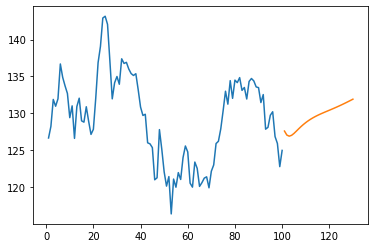

In [28]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

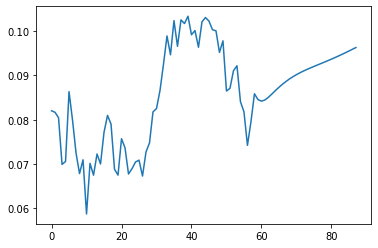

In [29]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [30]:
df3=scaler.inverse_transform(df3).tolist()


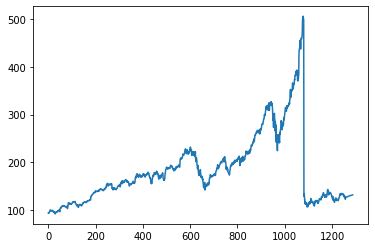

In [31]:
plt.plot(df3)
